external reference: https://www.chciken.com/digital/signal/processing/2020/05/13/guitar-tuner.html

In [1]:
import pyaudio
import scipy.signal as signal
import scipy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io.wavfile import read
from IPython.display import clear_output

%matplotlib notebook

In [2]:
# fixed chunk size
CHUNK = 1024 * 2
sampleRate = 44100

#initialize pyaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=sampleRate, input=True, frames_per_buffer=CHUNK)

In [3]:
#index = freqs
#mag = freq
#desiredMin = lowest frequency you would like to see for the analysis (actual min frequency might be lower)
#rate = rate at which to decrease the prominence, higher rate could be used to speed computation on data with a high max

def freqDetect(index, mag, desiredMin, rate):
    
    prominence = np.max(mag)
    peaks, _ = signal.find_peaks(mag, prominence = prominence)
    
    tempMin = 0
    while (True):
        try:
            peaks, _ = signal.find_peaks(mag, prominence = prominence)
            tempMin = np.min(index[peaks])

            if (tempMin != 0):
                #print('Successfully reached desired Bar Minimum!')
                break
            if (prominence <= 0):
                #print('Could not reach desired Bar Minimum!')
                break
            else:
                prominence -= rate
        except:
            prominence -= rate

    return peaks

In [4]:
#reference: https://www.johndcook.com/blog/2016/02/10/musical-pitch-notation/

from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [5]:
#data filter
fs = sampleRate
numtaps = 50
filt = signal.firwin(numtaps, [200,3000], pass_zero = False, fs = fs)

<IPython.core.display.Javascript object>


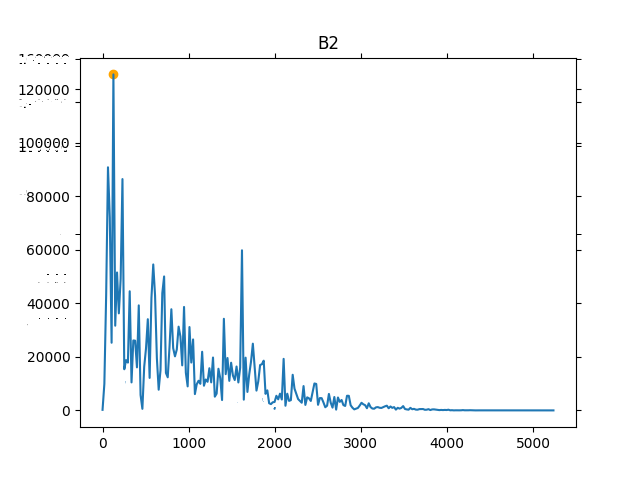

KeyboardInterrupt: 

In [9]:
#audio spectrum display
hist = []

#live plotting setup
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

#frequency monitor
temp = 0

while(True):
    #data stream and filter
    data = stream.read(CHUNK)
    data = np.frombuffer(data, dtype=np.int16)
    data = np.convolve(data,filt)
    
    #compute fft
    freq = fft.fft(data)
    freqs = fft.fftfreq(len(freq)) * sampleRate
    freq = freq[0:250]
    freqs = freqs[0:250]
    freq = np.abs(freq)
    
    #find prominent frequency
    ##peaks, _ = signal.find_peaks(freq, prominence = 1e6)
    #if (len(peaks) != 0):
        #val = np.round(freqs[peaks])
        
    peaks = freqDetect(freqs, freq, 50, 100)
    
    #live plotting
    ax.clear()
    ax.plot(freqs, freq)
    ax.scatter(freqs[peaks], freq[peaks], color = 'orange')
    ax.title.set_text(str(pitch(freqs[peaks])))
    fig.canvas.draw()

# close stream
stream.stop_stream()
stream.close()
p.terminate()